In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/clear_cloudy_merged/train_A_over"
plot_title = "train_A_over"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.508843,0.415,0.300393,0.415,0.446385,0.648325,0.714954,0.413320,0.471222,0.174227
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.738484,0.684,0.472949,0.684,0.539588,0.847058,0.791045,0.706382,0.559691,0.278033
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.804336,0.775,0.563091,0.775,0.602892,0.906436,0.825418,0.820879,0.628916,0.369507
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.818869,0.794,0.589919,0.794,0.630046,0.916475,0.835990,0.841143,0.649921,0.404762
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.813990,0.787,0.584486,0.787,0.623470,0.913280,0.837588,0.833874,0.669915,0.393722


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.707592,0.6380,0.523803,0.6380,0.628574,0.848951,0.840466,0.752606,0.650925,0.342513
1,2,test,0.819664,0.7905,0.636768,0.7905,0.709263,0.926483,0.892705,0.873267,0.732043,0.479512
2,3,test,0.856766,0.8415,0.691726,0.8415,0.745135,0.950198,0.913393,0.912694,0.776541,0.554139
3,4,test,0.866747,0.8545,0.709857,0.8545,0.762351,0.954833,0.918469,0.920596,0.788037,0.581562
4,5,test,0.865534,0.8520,0.709954,0.8520,0.762059,0.954874,0.921161,0.920221,0.796971,0.578426


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/403:,Train,Loss,=,1.535,Valid,Loss,=,1.539,ETA,=,6.67h
1,Epoch,"1/40,",Batch,20/403:,Train,Loss,=,1.538,Valid,Loss,=,1.505,ETA,=,6.21h
2,Epoch,"1/40,",Batch,30/403:,Train,Loss,=,1.452,Valid,Loss,=,1.444,ETA,=,5.17h
3,Epoch,"1/40,",Batch,40/403:,Train,Loss,=,1.412,Valid,Loss,=,1.410,ETA,=,5.40h
4,Epoch,"1/40,",Batch,50/403:,Train,Loss,=,1.375,Valid,Loss,=,1.358,ETA,=,5.17h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.535,1.539
20,1,20,1.538,1.505
30,1,30,1.452,1.444
40,1,40,1.412,1.410
50,1,50,1.375,1.358


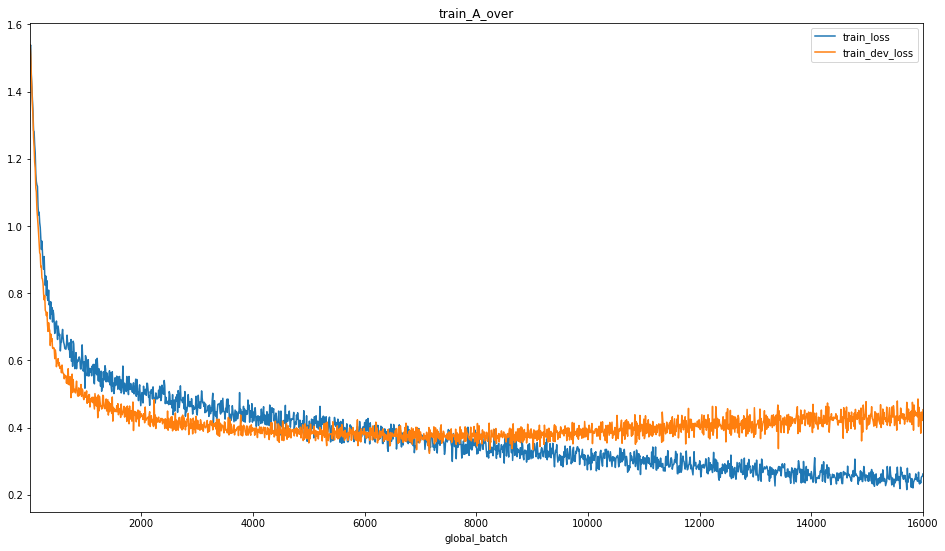

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,0.9600,0.8790
2,0.6555,0.5620
3,0.5810,0.4930
4,0.5420,0.4590
5,0.5150,0.4445


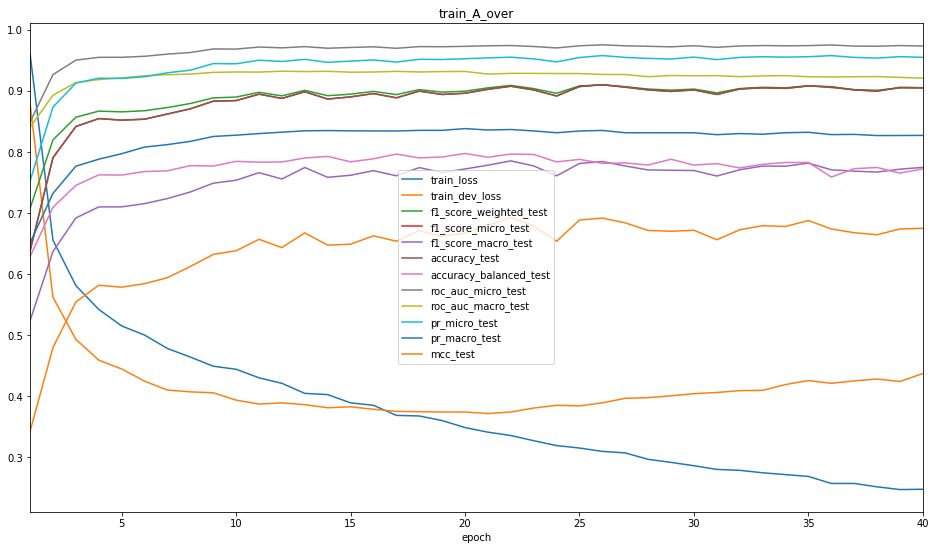

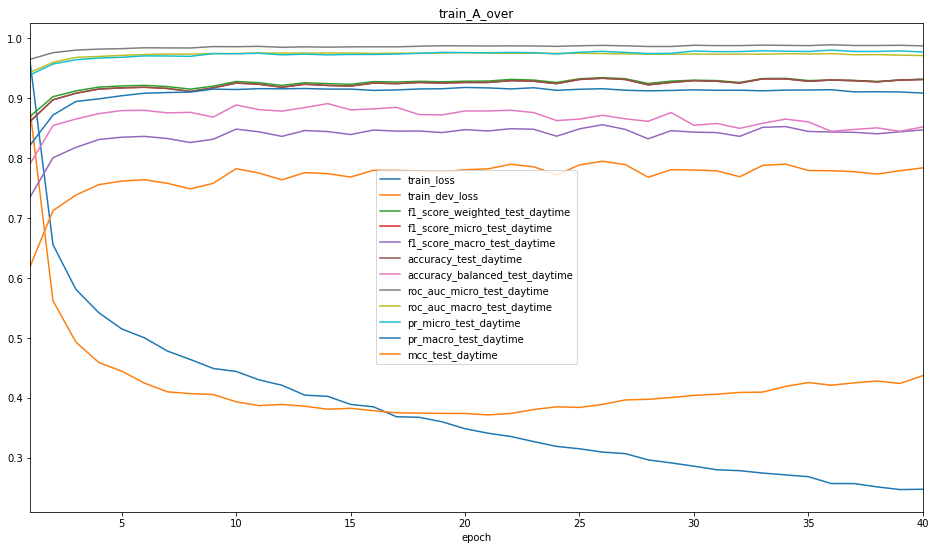

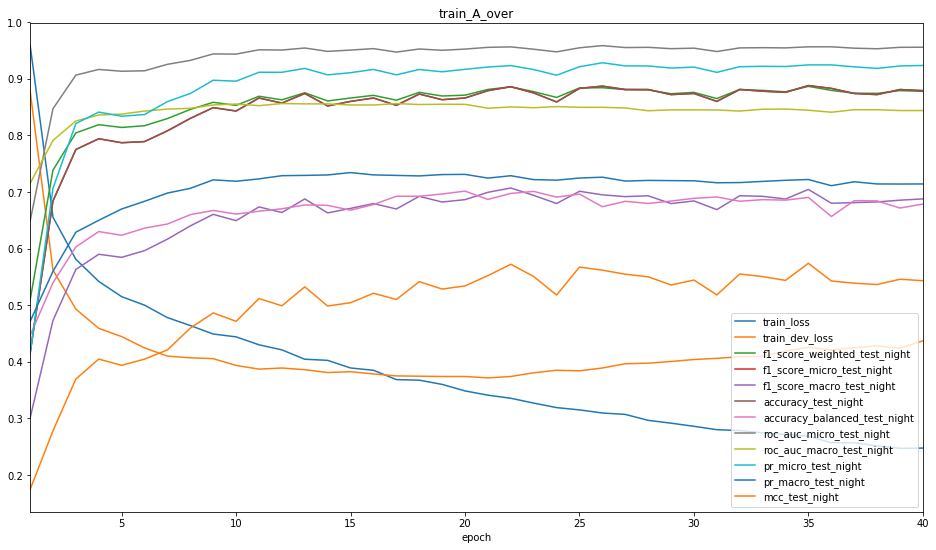

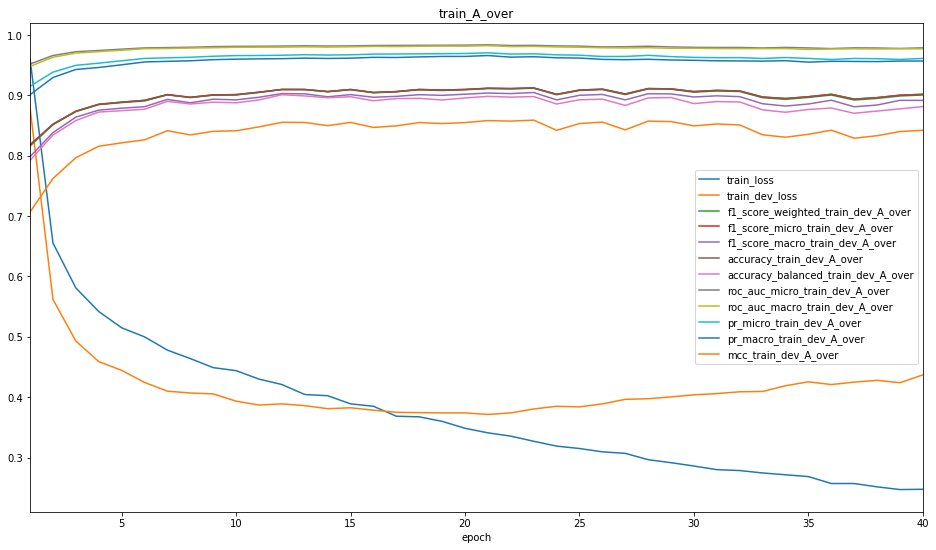

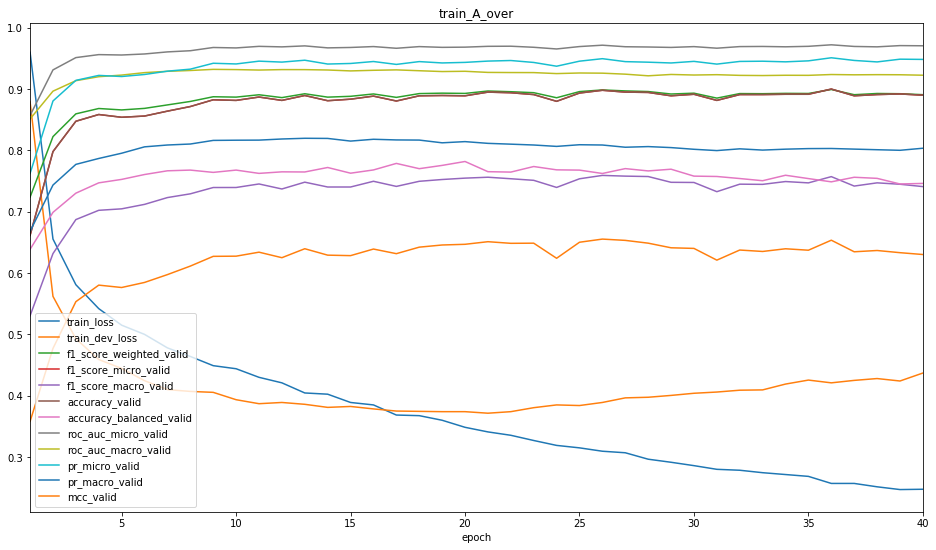

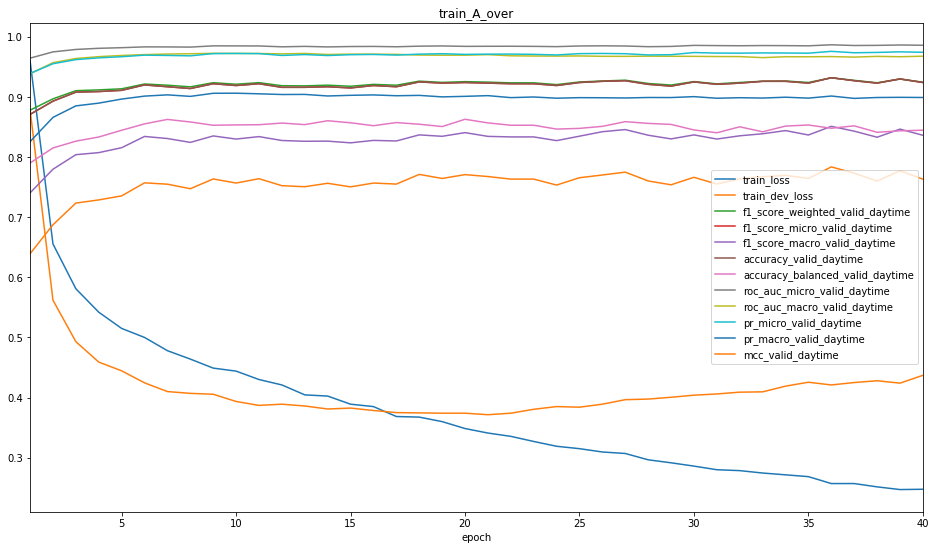

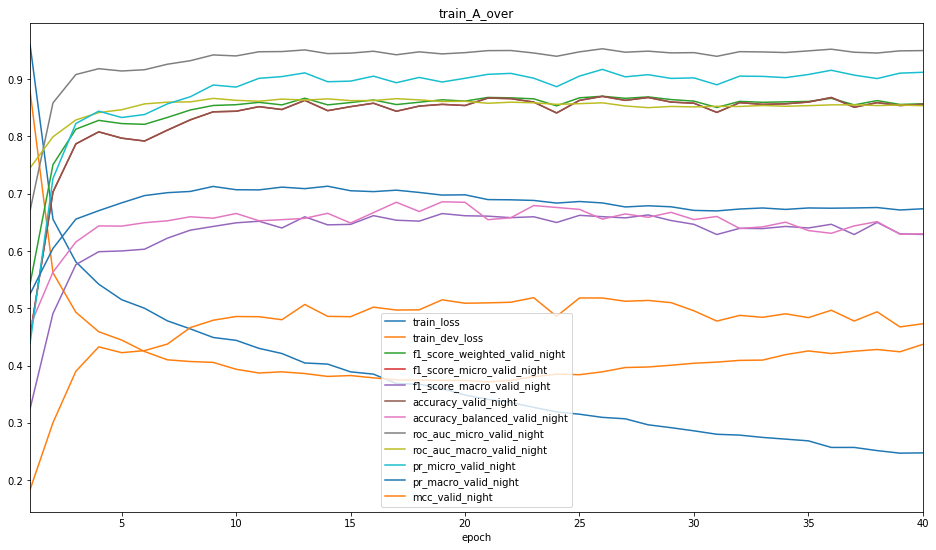

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)